Evan Edelstein
EN.605.645.82.SP26

In [40]:
%matplotlib inline

# Module 3 - Programming Assignment

## General Directions

1. You must follow the Programming Requirements outlined on Canvas.
2. The Notebook should be cleanly and fully executed before submission.
3. You should change the name of this file to be your JHED id. For example, `jsmith299.ipynb` although Canvas may change it to something else...and that's ok.

<div style="background: lemonchiffon; margin:20px; padding: 20px;">
    <strong>Important</strong>
    <p>
        You should always read the entire assignment before beginning your work, so that you know in advance what the requested output will be and can plan your implementation accordingly.
    </p>
</div>

<div style="color: white; background: #C83F49; margin:20px; padding: 20px;">
    <strong>Academic Integrity and Copyright</strong>
    <p>You are not permitted to consult outside sources (Stackoverflow, YouTube, ChatGPT, etc.) or use "code assistance" (Co-Pilot, etc) to complete this assignment. By submitting this assignment for grading, you certify that the submission is 100% your own work, based on course materials, group interactions, instructor guidance. You agree to comply by the requirements set forth in the Syllabus, including, by reference, the JHU KSAS/WSE Graduate Academic Misconduct Policy.</p>
    <p>Sharing this assignment either directly (e.g., email, github, homework site) or indirectly (e.g., ChatGPT, machine learning platform) is a violation of the copyright. Additionally, all such sharing is a violation the Graduate Academic Misconduct Policy (facilitating academic dishonesty is itself academic dishonesty), even after you graduate.</p>
    <p>If you have questions or if you're unsure about the policy, ask via Canvas Inbox. In this case, being forgiven is <strong>not</strong> easier than getting permission and ignorance is not an exuse.</p>
    <p>This assignment is copyright (&copy Johns Hopkins University &amp; Stephyn G. W. Butcher). All rights reserved.</p>
</div>

# The Problem

When we last left our agent in Module 1, it was wandering around a world filled with plains, forests, swamps, hills and mountains. This presupposes a map with known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

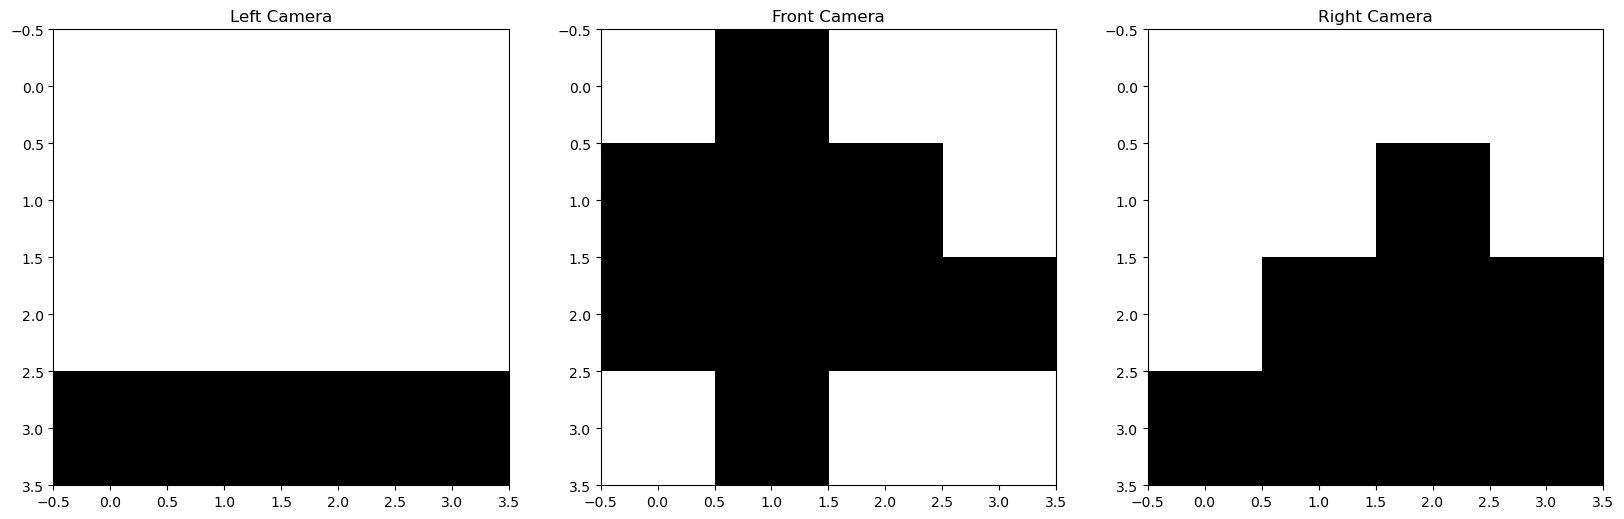

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
hills = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
swamp = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype="uint8")
pixels = pixels.reshape((4, 4))
axes.set_title("Left Camera")
axes.imshow(pixels, cmap="gray")

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype="uint8")
pixels = pixels.reshape((4, 4))
axes.set_title("Front Camera")
axes.imshow(pixels, cmap="gray")

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype="uint8")
pixels = pixels.reshape((4, 4))
axes.set_title("Right Camera")
axes.imshow(pixels, cmap="gray")

plt.show()
plt.close()

which would be plains, forest and hills respectively.

## The Assignment

For this programming assignment your tasks are:

1. Write a logistic regression that simply determines if something is a hill or not (two class problem). 
2. You will also evaluate that logistic regression by generating a *confusion matrix*.

For a starting point, refer to the Pseudocode and the Self-Check.

## Data

We have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often noisy.

Here are the clean examples with different registrations: 

In [42]:
clean_data = {
    "plains": [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"],
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"],
    ],
    "swamp": [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]],
}

Let's create a function that allows us to view any of these:

In [43]:
def view_sensor_image(data):
    figure = plt.figure(figsize=(4, 4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype="uint8")
    pixels = pixels.reshape((4, 4))
    axes.set_title("Left Camera:" + data[-1])
    axes.imshow(pixels, cmap="gray")
    plt.show()
    plt.close()

"I think that I shall never see a thing so lovely as a tree."

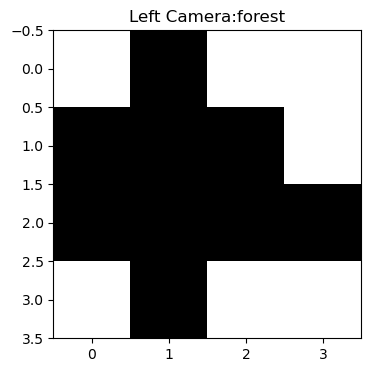

In [44]:
view_sensor_image(clean_data["forest"][0])

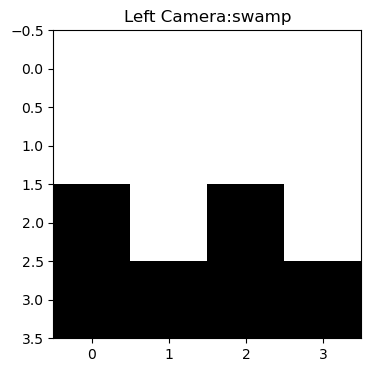

In [45]:
view_sensor_image(clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values that should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [46]:
def blur(data):
    def apply_noise(value):
        if value < 0.5:
            v = random.gauss(0.30, 0.07)  # (0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss(0.70, 0.07)  # (0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v

    noisy_readings = [apply_noise(v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

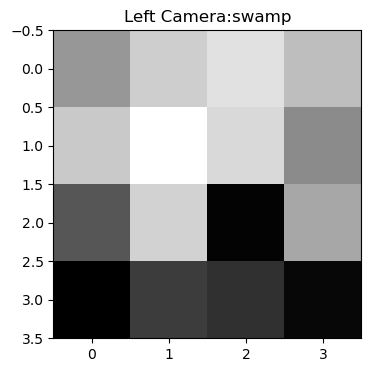

In [47]:
view_sensor_image(blur(clean_data["swamp"][0]))

We need four (4) functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`
4. `evaluate`

### generate_data

`generate_data` has been written for you.

* clean_data - the clean versions of the "bitmaps" for each of the terrain types
* n - the number of samples for "in the class" (1) and "not in the class" (0) to generate.
* label - the label to chose as "in the class".

For example,

`generate_data( clean_data, 100, "hills")`

generates 100 hills, 100 not hills and has transformed the String labels into 1 and 0, respectively.

### `learn_model`

`learn_model` is the function that takes in training data and actually learns the logistic regression model.

*In the lecture, I mentioned that you usually should mean normalize your data but you don't need to do that in this case because the data is already on the range 0-1.*

For this problem, an `epsilon` of 1e-5 is a good balance between accuracy and time to convergence. Additionally, it'll make sure we all generally get the same results. You should start with an `alpha` of 0.1 and then make it adaptive as described in the Pseudocode.

When developing your algorithm, you need to watch the error so you'll set verbose=True to start. You should print it out every iteration and make sure it is declining. You don't need to run it to convergence...you'll know pretty quickly if you're doing the right thing. When you know that your algorithm is working, change your code so that the error is printed out only every 1,000 iterations (it takes a lot of iterations for this problem to converge, depending on your parameter values--start early).

`learn_model` returns the List of Thetas.

### `apply_model`

`apply_model` takes a List of Thetas (the model) and lableled data. You will return a List of Tuples. Each Tuple will contain the actual $y$ value and the predicted y value ($\hat{y}) as the probability.

### `evaluate`

Ideally, we should be doing the model evaluation things we learned this module. Instead, we're just going to print out:

1. the error rate
2. a confusion matrix.

```
{"TN": 0, "TP": 0, "FN": 0, "FP": 0}
```
The main reason we're not going to do more is that the full 5x2 cross validation, validation curves, learning curves approach to model evaluation would take too long with this algorithm (at least as an assignment). In the real world, you would just have to bite the bullet and do it although the algorithm could be run in parallel and the results combined.

We will ask you to do these things on later assignments so be prepared.

**As always when working with Lists or Lists of Lists, be very careful when you are modifying these items in place that this is what you want.**

In [ ]:
from math import exp, log10, sqrt
from typing import List, Tuple, Dict

bound_log
<a id="bound_log"></a>
## bound_log

*`bound_log` calculate the base 10 log value of a number, return zero if the number is not positive*  **Used by**: [calc_error](#calc_error)

* **x** float: input value

**returns** float - base 10 log value for positive numbers, else zero

In [49]:
def bound_log(x: float) -> float:
    return log10(x) if x > 0.0 else 0.0

In [50]:
# Tests
assert bound_log(12) == log10(12)  # normal
assert bound_log(0) == 0  # zero as input
assert bound_log(-10938) == 0  # negative input

<a id="parse_data"></a>
## parse_data

`parse_data` Parse input data matrix into 2d list of features, and 1d list of observables (y values). Insert a dummy variable of 1 to each feature list in order to maintain to use $\theta_0$ as the y-intercept. If the features do not contain the same number of values, a None tuple is returned  **Used by**: [generate_data](#generate_data) and [apply_model](#apply_model)

* **data** List[Tuple[List[float], int]]: 2d data matrix. each row is a tuple where the first entry is a list of features (xs) and the second field is the target variable (y)

**returns** Tuple[List[List[float]], List[int]] | Tuple[None, None]: parsed input data, a tuple where the first entry is a 2d list of features (xs) with an added dummy column and the second field is the target variable (y)

In [51]:
def parse_data(data: List[Tuple[List[float], int]]) -> Tuple[List[List[float]], List[int]] | Tuple[None, None]:
    features: List[List[float]] = [i[0] for i in data]
    ys: List[int] = [i[1] for i in data]

    if not all(len(i) == len(features[0]) for i in features[1:]):
        return None, None

    if not all(float(i[0]) == 1.0 for i in features):
        for i in features:  # add in dummy variable
            i.insert(0, 1.0)

    return features, ys

In [52]:
# test 1: normal
matrix = [([1.0, 2.0, 3.0], 4), ([1.0, 5.0, 6.0], 7)]
f, y = parse_data(matrix)
assert f == [[1.0, 2.0, 3.0], [1.0, 5.0, 6.0]]
assert y == [4.0, 7.0]

# test 2:  does not add dummy if exists
matrix = [([2.0, 3.0], 4), ([5.0, 6.0], 7)]
f, y = parse_data(matrix)
assert f == [[1.0, 2.0, 3.0], [1.0, 5.0, 6.0]]
assert y == [4.0, 7.0]

# test 3:  malformed features return None
matrix = [([2.0, 3.0], 4), ([1.0, 5.0, 6.0], 7)]
f, y = parse_data(matrix)
assert f is None
assert y is None


<a id="init_thetas"></a>
## init_thetas

`init_thetas` generate a list of size floats in the range [low, high] using a pseudo-random number generator **Used by**: [learn_model](#learn_model)

* **size** int: number of values to generate 
* **low** int: lower bound of value to produce
* **high** int: upper bound of value to produce 

**returns** List[float] - list of floats

In [53]:
def init_thetas(size: int, low: int, high: int) -> List[float]:
    return [random.uniform(low, high) for _ in range(size)]

In [54]:
# Tests
ts = init_thetas(1, -1, 1)
assert -1 <= ts[0] <= 1  # value is in range of [high, low]

ts = init_thetas(0, -1, 1)
assert len(ts) == 0  # if size is zero return empty list

ts = init_thetas(1, 1, 1)
assert ts == [1]  # if high == low then return high

<a id="calculate_estimates"></a>
## calculate_estimates

`calculate_estimates` Given a list of per-feature weights and a 2d list of features per observation, compute the estimate value for each row of features. Mathematically, the estimate for each observation is: $\hat{y} = \frac{1}{1+e^{-z}}$ where z is the vector matrix product of the list of weights (theta) and x is the feature row. $z = \theta x$. We can write this as $z(n) = \theta[0] * x[n][0] + \theta[1] * x[n][1] ... + theta[n] * x[n][m]$ for n observations and m features **Used by**: [learn_model](#learn_model) and [apply_model](#apply_model)

* **thetas** List[float]: list of model weights 
* **features** List[List[float]]: 2d list of features per observation

**returns** List[float] - list of estimates for each observation

In [55]:
def calculate_estimates(thetas: List[float], features: List[List[float]]) -> List[float]:
    zs = [0.0] * len(features)
    # z(n) = theta[0] * x[n][0] + theta[1] * x[n][1] ... + theta[n] * x[n][m]
    for c, xs in enumerate(features):
        for t, x in zip(thetas, xs):
            zs[c] += t * x
    # 1/ (1 + e^-z)
    yhats: List[float] = [1.0 / (1.0 + exp(-1.0 * z)) for z in zs]
    return yhats

In [56]:
# Tests

thetas = [0.8, 1.1]
features = [[1.0, 1.1], [1.0, 2.7]]
yhats = calculate_estimates(thetas, features)
assert [round(yhat, 3) for yhat in yhats] == [0.882, 0.977]  # test 1 - manual calculation

thetas = [0.757, 1.055]
features = [[1.0, 1.1], [1.0, 2.7]]
yhats = calculate_estimates(thetas, features)
assert [round(yhat, 3) for yhat in yhats] == [0.872, 0.974]  # test 2 - manual calculation

thetas = [0.0, 0.0, 0.0]
features = [[1.0, 123.45], [1.0, 678.9]]
yhats = calculate_estimates(thetas, features)
assert yhats == [0.5, 0.5]  # test 3 - zero thetas produce yhat of 0.5 (z = 0 => yhat = 1/2)


<a id="calculate_error"></a>
## calculate_error

`calculate_error`  given a list of real values and corresponding list of estimates, calculate the log-loss error. Error is calculated by $error = y * log(\hat{y}) + (1-y) * log(1-\hat{y})$. Returns None if the target variable is not 0 or 1. **Uses** [bound_log](#bound_log) to safely compute the logarithm **Used by**: [learn_model](#learn_model)

* **ys** List[int]: observed values 
* **yhats** List[float]: estimates 

**returns** float | None - log error or None if target variable is invalid

In [57]:
def calculate_error(ys: List[int], yhats: List[float]) -> float | None:
    error = 0.0
    for yh, y in zip(yhats, ys):
        if y not in {0, 1}:
            return None
        error += y * bound_log(yh) + (1 - y) * bound_log(1 - yh)

    error = (-1.0 / len(ys)) * error
    return error

In [58]:
# Tests
ys = [0]
yahts = [0]
error = calculate_error(ys, yhats)
assert error is not None and round(error, 3) == 0.301  # test 1 - error is well defined even for y and yhat == 0

ys = [0]
yahts = [-1.2]
error = calculate_error(ys, yhats)
assert error is not None and round(error, 3) == 0.301  # test 2 - error is well defined even for y and yhat == 0

ys = [2]
yahts = [-1.2]
error = calculate_error(ys, yhats)

assert error is None  # test 3 - error is none if target variable is non-binary


<a id="calculate_thetas"></a>
## calculate_thetas

`calculate_thetas` Given a list of weights per feature, a 2d list of features per observation, target variables and target estimates, produce new weights using $\theta_j = \theta_j - \alpha * \frac{\partial J}{\partial \theta_j}$ where $\frac{\partial J}{\partial \theta_j} = \frac{1}{n}\sum_i^n(\hat{y_i} - y)x_{ij}, j \in 0...m$ **Used by**: [learn_model](#learn_model)


* **thetas** List[float]: list of model weights 
* **features** List[List[float]]: 2d list of features per observation
* **ys** List[int]: observed values 
* **yhats** List[float]: estimates 
* **alpha** float: learning parameter

**returns** List[float] - new thetas

In [59]:
def calculate_thetas(thetas: List[float], features: List[List[float]], ys: List[int], yhats: List[float], alpha: float) -> List[float]:
    n = len(ys)

    ds = [(yh - y) for yh, y in zip(yhats, ys)]

    js = [0.0] * len(thetas)
    for c, xs in enumerate(features):
        for j, x in enumerate(xs):
            js[j] += x * ds[c]

    thetas = [t - alpha * j / n for t, j in zip(thetas, js)]
    return thetas

In [60]:
# Tests
thetas = [0.8, 1.1]
features = [[1.0, 1.1], [1.0, 2.7]]
ys = [0, 1]
yhats = [0.882, 0.977]
alpha = 0.1
nthetas = calculate_thetas(thetas, features, ys, yhats, alpha)
assert [round(t, 3) for t in nthetas] == [0.757, 1.055]  # test 1 - manual calculation

thetas = [0.8, 1.1]
features = [[1.0, 1.1], [1.0, 2.7]]
ys = [0, 1]
yhats = [0.882, 0.977]
alpha = 0.01
nthetas2 = calculate_thetas(thetas, features, ys, yhats, alpha)
assert calculate_error(ys, calculate_estimates(nthetas2, features)) > calculate_error(ys, calculate_estimates(nthetas, features))  # type: ignore # test 2 - decreasing alpha influences theta

thetas = [0.8, 1.1]
features = [[1.0, 1.1], [1.0, 2.7]]
ys = [0, 1]
yhats = [0.0, 1.0]
alpha = 0.1
nthetas3 = calculate_thetas(thetas, features, ys, yhats, alpha)
assert nthetas3 == thetas  # test 3 - if y == yhats then thetas dont change

---

Put your helper functions above here.

## Main Functions

Use `generate_data` to generate a balanced set of blurred "hills" and "not-hills" examples to test that the function is working.

In [61]:
def generate_data(data, n, key_label):
    labels = list(data.keys())
    labels.remove(key_label)

    total_labels = len(labels)
    result = []
    # create n "not label" and code as y=0
    count = 1
    while count <= n:
        label = labels[count % total_labels]
        datum = blur(random.choice(data[label]))
        xs = datum[0:-1]
        result.append((xs, 0))
        count += 1

    # create n "label" and code as y=1
    for _ in range(n):
        datum = blur(random.choice(data[key_label]))
        xs = datum[0:-1]
        result.append((xs, 1))
    random.shuffle(result)
    return result

In [62]:
results = generate_data(clean_data, 5, "hills")
for result in results:
    print(result)

([0.19791664931107603, 0.3817328270106967, 0.3638574288969237, 0.3498438561046203, 0.7532071478897439, 0.44797019937891325, 0.29365769708635836, 0.38590507613731684, 0.6642895685661683, 0.796859954227671, 0.3598953046759033, 0.3906563802175737, 0.807791273731932, 0.8250204787556175, 0.7198375891971371, 0.3217492141408443], 1)
([0.37662516308490696, 0.2195620609633609, 0.2638617287827323, 0.2571762304891194, 0.2866100625075757, 0.22537172381497877, 0.2982779109880655, 0.32224889223534464, 0.7803627655239191, 0.2957204670220096, 0.6416700128572593, 0.26578980693287874, 0.7806362667840225, 0.7264347169422586, 0.691476500998497, 0.7622176090696138], 0)
([0.2797698975425773, 0.6470896778804458, 0.25369969360950545, 0.3235260741053298, 0.7184448524539321, 0.7006052093285815, 0.6369482986099515, 0.4379587120150813, 0.7311006809293666, 0.6087379221334274, 0.7949092254706265, 0.6693036291505571, 0.3312627583494447, 0.6819269692643585, 0.355721882631861, 0.2696050227439848], 0)
([0.2481753716780

<a id="learn_model"></a>
## learn_model

`learn_model` Given a set of training data, compute the model weights using logistic regression. The input data is a 2d data matrix where each row is a tuple. The first entry of the tuple is a list of features (xs) and the second field is the target variable (y). The algorithm begins by formatting the input data as a set of observed features and list of target variables. Next, a set of per-feature model weight is randomly generated. Then, using a gradient decent algorithm, the model weights are tuned. In each iteration of the decent a set of estimate values (yhats) is calculated from the model weight and features, following the logistic regression formula $\hat{y} = \frac{1}{1+e^{-\theta * x}}$ where $\theta * x$ is the matrix product of the weights vector and the feature matrix. Next, the error between the estimate and real values is calculated using a log-loss formula: $error = y * log(\hat{y}) + (1-y) * log(1-\hat{y})$. Lastly, the weights are updated according to the formula: $\theta_j = \theta_j - \alpha * \frac{\partial J}{\partial \theta_j}$ where $\frac{\partial J}{\partial \theta_j} = \frac{1}{n}\sum_i^n(\hat{y_i} - y)x_{ij}, j \in 0...m, i \in 0..n$ for m features and n observations. If the error is not decreasing the learning rate, $\alpha$ is decreased by an order of magnitude. This help ensure the gradient decent algorithm doesn't overshoot the minimum error weights. This algorithm continues until the absolute difference between error before and after an iteration is greater then a cutoff ($\epsilon$). **Uses** [parse_data](#parse_data), [init_thetas](#init_thetas), [calculate_estimates](#calculate_estimates), [calculate_error](#calculate_error), [calculate_thetas](#calculate_thetas)

* **data** List[Tuple[List[float], int]]: 2d data matrix. each row is a tuple where the first entry is a list of features (xs) and the second field is the target variable (y)
* **verbose** bool: if true print progress  
* **epsilon** float: error cutoff
* **alpha** float: learning rate
* **print_freq** int: report progress for every nth iteration of the algorithm

**returns** List[float]: final model weights

In [ ]:
def learn_model(data: List[Tuple[List[float], int]], verbose: bool = False, epsilon: float = 10**-5, alpha: float = 0.1, print_freq: int = 1000) -> List[float]:
    features, ys = parse_data(data)

    if features is None or ys is None:  # input error
        raise Exception("Input data is malformed - observations should have the same number of features and be of the form [ ([x1, x2, x3], y), ([x1, x2, x3], y) ]")

    num_thetas = len(features[0])
    thetas: List[float] = init_thetas(num_thetas, -1, 1)

    prev_error: float = 0.0
    yhats: List[float] = calculate_estimates(thetas, features)
    curr_error: float | None = calculate_error(ys, yhats)
    if curr_error is None:
        raise Exception("Target Variable is not 0 or 1")

    if verbose:
        print("Iter\tError")

    iterations = 0
    while abs(curr_error - prev_error) >= epsilon:
        thetas = calculate_thetas(thetas, features, ys, yhats, alpha)
        prev_error = curr_error

        yhats = calculate_estimates(thetas, features)
        curr_error = calculate_error(ys, yhats)
        if curr_error is None:
            raise Exception("Target Variable is not a binary number")

        if curr_error > prev_error:
            alpha /= 10

        if verbose and (iterations % print_freq == 0):
            print(f"{iterations}\t{curr_error:.6f}")

        iterations += 1

    return thetas

In [ ]:
# Tests

data = [([1.0, 2.0, 3.0], 0)]
thetas = learn_model(data)
assert len(thetas) == 3  # test 1 - correct number of thetas - y-intercept not added

data = [([2.0, 3.0, 4.0], 1), ([5.0, 6.0, 7.0], 0)]
thetas = learn_model(data)
assert len(thetas) == 4  # test 2 correct number of thetas - y-intercept added

data = generate_data(clean_data, 10, "hills")
thetas = learn_model(data)
assert len(thetas) == 17  # test 3 - correct number of thetas when used w generated data

<a id="apply_model"></a>
## apply_model

`apply_model` Given a set of model weights and input data, estimate the value for each set of observations. **Uses** [calculate_estimates](#calculate_estimates)


* **model** List[float]: list of trained feature weights 
* **test_data** List[Tuple[List[float], int]] 2d data matrix. each row is a tuple where the first entry is a list of features (xs) and the second field is the target variable (y)

**returns** List[Tuple[int, float]] - list of tuples where the first entry as the real value and the second entry as the value estimated using the model

In [65]:
def apply_model(model: List[float], test_data: List[Tuple[List[float], int]]) -> List[Tuple[int, float]]:
    features, ys = parse_data(test_data)

    if features is None or ys is None:  # input error
        raise Exception("Input data is malformed - observations should have the same number of features and be of the form [ ([x1, x2, x3], y), ([x1, x2, x3], y) ]")

    yhats = calculate_estimates(model, features)
    result = [(y, yhat) for y, yhat in zip(ys, yhats)]
    return result

In [ ]:
# Tests
data = generate_data(clean_data, 100, "hills")
thetas = learn_model(data)

test_data = generate_data(clean_data, 10, "hills")
result = apply_model(thetas, test_data)
assert len(result) == len(test_data)  # test 1 - correct number of yhats when used w generated data

test_data = generate_data(clean_data, 100, "hills")
result = apply_model(thetas, test_data)
assert len(result) == len(test_data)  # test 2 - correct number of yhats when used w generated data

test_data = generate_data(clean_data, 1000, "hills")
result = apply_model(thetas, test_data)
assert len(result) == len(test_data)  # test 3 - correct number of yhats when used w generated data



<a id="evaluate"></a>
## evaluate

`evaluate` Given a list of target value and estimates compute a confusion matrix, percent error and model evaluation metrics. A confusion matrix is a 2x2 matrix that stratifies the estimates by True Positive, True Negative, False Positive or False Negative. True Positives are "1" estimates that have "1" target value, while True Negative are observations with "0" estimate and a real value of "0". Conversely, False Positives have an estimate of "1" but are really "0" and False Negative have an estimate of "0" but are really "1". With theses quantities, we can define error as $error = \frac{FN + FP}{n}$ where n is the number of observations. Similarly we can define accuracy, or how well the model correctly estimated a value as $\frac{TP + TN}{n}$. A more informative set of metrics are precision ($\frac{TP}{TP + FP}$) and recall ($\frac{TP}{TP + FN}$). Precision measures the ratio of correct positive estimates to all positive estimates, while recall quantifies the number of correct positives out of all the actual positive targets in the data set. Two "extra" measures of model evaluation f1-score and Matthews Correlation Coefficient (MCC) are calculated, both these metrics aim to measure the models balance of precision and recall.

* **results** List[Tuple[int, float]]: list of tuples where the first entry as the real value and the second entry as the value estimated using the model
* **threshold** float: threshold above which or equal to an estimate is considered "1", otherwise "0"

**returns** Tuple[Dict[str, int], float, Dict[str, float]]: a tuple, the first entry is the confusion matrix, the second entry is the percent error and the third entry is a dictionary of extra model evaluation metrics

In [ ]:
def evaluate(results: List[Tuple[int, float]], threshold: float = 0.5) -> Tuple[Dict[str, int], float, Dict[str, float]]:
    confusion_matrix: Dict[str, int] = {"TN": 0, "TP": 0, "FN": 0, "FP": 0}

    for y, yhat in results:
        if yhat >= threshold and y == 1:
            confusion_matrix["TP"] += 1

        elif yhat < threshold and y == 0:
            confusion_matrix["TN"] += 1

        elif yhat >= threshold and y == 0:
            confusion_matrix["FP"] += 1

        elif yhat < threshold and y == 1:
            confusion_matrix["FN"] += 1

        else:
            raise Exception(f"Unable to classify yhat: {yhat}, y:{y}")

    n = len(results)

    TP = confusion_matrix["TP"]
    FP = confusion_matrix["FP"]
    TN = confusion_matrix["TN"]
    FN = confusion_matrix["FN"]

    # percent error rate
    percent_error = ((FN + FP) / n) * 100

    # basic confusion matrix evaluators
    accuracy = (TP + TN) / n
    recall = TP / TP + FN
    precision = TP / TP + FP

    # some "advanced" confusion matrix evaluators
    fscore = 2 * (precision * recall) / (precision + recall)
    mcc = (TP * TN - FP * FN) / sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    metrics: Dict[str, float] = {"accuracy": accuracy, "recall": recall, "precision": precision, "fscore": fscore, "mcc": mcc}

    return confusion_matrix, percent_error, metrics

In [ ]:
# Tests
data = generate_data(clean_data, 100, "hills")
thetas = learn_model(data)

test_data = generate_data(clean_data, 10, "hills")
result = apply_model(thetas, test_data)
confusion_matrix, percent_error, metrics = evaluate(result)
assert percent_error > 0.0  # test 1 - positive percent error

test_data = generate_data(clean_data, 100, "hills")
result = apply_model(thetas, test_data)
confusion_matrix, percent_error, metrics = evaluate(result)
assert percent_error > 0.0  # test 2 - positive percent error

test_data = generate_data(clean_data, 1000, "hills")
result = apply_model(thetas, test_data)
confusion_matrix, percent_error, metrics = evaluate(result)
assert percent_error > 0.0  # test 3 - positive percent error


## Use your code

Use `generate_data` to generate 100 blurred "hills" examples balanced with 100 "non hills" examples and use this as your test data. Print out the first 10 results, one per line.

In [69]:
train_data = generate_data(clean_data, 100, "hills")

for row in train_data[:10]:
    print(row)

([0.646905248126453, 0.29433625164190486, 0.2776384665190591, 0.33857474055110964, 0.7330283028270412, 0.680505347613232, 0.300868813254652, 0.3071726532909978, 0.6685609458500245, 0.7194641396266934, 0.7552849359379122, 0.21825419001194887, 0.7521819955059457, 0.16784189092276453, 0.22910936213929678, 0.26488951672108163], 0)
([0.29577237668589, 0.7094314761897341, 0.21079438883526969, 0.22511023294591848, 0.6926390199784445, 0.700085111650516, 0.7528722714527148, 0.19845515240958794, 0.6528154063234903, 0.7494972900168996, 0.6762124185574461, 0.6877406616404179, 0.32662646448578164, 0.7109155564281093, 0.22849248465675054, 0.38743440334578994], 0)
([0.3056488072000333, 0.3377662167499469, 0.3653109605707616, 0.6650727838201379, 0.2845805051188896, 0.4676000669792354, 0.5909774004562639, 0.6296911912722714, 0.28163654480320505, 0.6462303876514321, 0.7318829714062619, 0.7704611047428592, 0.1431781851243864, 0.1628676293201995, 0.3412233053610251, 0.7296351071091818], 0)
([0.29990482520

In [70]:
test_data = generate_data(clean_data, 100, "hills")
for row in test_data[:10]:
    print(row)

([0.3631669407422706, 0.397543132943176, 0.3528072022429371, 0.31801326606969743, 0.2676666327277914, 0.30691658780944464, 0.2374656844782471, 0.2655822658499821, 0.7145869281269724, 0.31946065622612313, 0.6269817257895227, 0.32462163163233504, 0.7475500855259891, 0.6633218476788699, 0.7012001793550611, 0.9544730325068937], 0)
([0.3050308126106889, 0.27165900750639993, 0.23337108420005376, 0.31477393297793593, 0.3265294117667656, 0.25037027580739163, 0.37428126867560396, 0.743187696863709, 0.2812715723737176, 0.2747390294557985, 0.6477922312416917, 0.5717591397540461, 0.31527651134263673, 0.7594167755736244, 0.7968443474125346, 0.5961626376417991], 1)
([0.18387478703607998, 0.3600860002374008, 0.28051296661184716, 0.46812274427019784, 0.2623414719650137, 0.6918365153579089, 0.267872996956353, 0.2665230612294008, 0.7679749575913867, 0.667731946052752, 0.5840854448950074, 0.3359086209739042, 0.7463911405797135, 0.7539587081338732, 0.5711760411794602, 0.5772163767300464], 1)
([0.320182663

Use `learn_model` to learn a logistic regression model for classifying sensor images as "hills" or "not hills". Use your `generate_data` function to generate a training set of size 100 for "hills". **Set Verbose to True**

In [71]:
model = learn_model(train_data, True)

Iter	Error
0	0.352348
1000	0.232697
2000	0.198399
3000	0.178209
4000	0.164768


Apply the model to the test data:

In [72]:
results = apply_model(model, test_data)

Using the results above, print out your error rate (as a percent) and the confusion matrix:

In [73]:
confusion_matrix, percent_error, metrics = evaluate(results)
print(f"Error Rate: {percent_error}%")
print(f"Confusion Matrix: {confusion_matrix}")

# print(f"Extra Metrics: {metrics}")

Error Rate: 18.0%
Confusion Matrix: {'TN': 85, 'TP': 79, 'FN': 21, 'FP': 15}


## Before You Submit...

1. Did you provide output exactly as requested?
2. Did you re-execute the entire notebook? ("Restart Kernel and Rull All Cells...")
3. If you did not complete the assignment or had difficulty please explain what gave you the most difficulty in the Markdown cell below.
4. Did you change the name of the file to `jhed_id.ipynb`?

Do not submit any other files.